# 『深度学习7日打卡营』人脸关键点检测

## 一、问题定义

人脸关键点检测，是输入一张人脸图片，模型会返回人脸关键点的一系列坐标，从而定位到人脸的关键信息。

![](https://ai-studio-static-online.cdn.bcebos.com/b0d8d5ed9d1646899acea372ce6f16626ffb68aa457a40e993c8b6b65cb8a67b)



In [1]:
# 环境导入
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import paddle

paddle.set_device('gpu') # 设置为GPU

import warnings 
warnings.filterwarnings('ignore') # 忽略 warning

## 二、数据准备

### 2.1 下载数据集
本次实验所采用的数据集来源为github的[开源项目](https://github.com/udacity/P1_Facial_Keypoints)

目前该数据集已上传到 AI Studio [人脸关键点识别](https://aistudio.baidu.com/aistudio/datasetdetail/69065)，加载后可以直接使用下面的命令解压。

In [ ]:
!unzip data/data76134/data.zip

解压后的数据集结构为
```
data/
|—— test
|   |—— Abdel_Aziz_Al-Hakim_00.jpg
    ... ...
|—— test_frames_keypoints.csv
|—— training
|   |—— Abdullah_Gul_10.jpg
    ... ...
|—— training_frames_keypoints.csv
```
其中，``training`` 和 ``test`` 文件夹分别存放训练集和测试集。``training_frames_keypoints.csv`` 和 ``test_frames_keypoints.csv`` 存放着训练集和测试集的标签。接下来，我们先来观察一下 ``training_frames_keypoints.csv`` 文件，看一下训练集的标签是如何定义的。

In [2]:
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv') # 读取数据集
print('Number of images: ', key_pts_frame.shape[0]) # 输出数据集大小
key_pts_frame.head(5) # 看前五条数据

Number of images:  3462


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


上表中每一行都代表一条数据，其中，第一列是图片的文件名，之后从第0列到第135列，就是该图的关键点信息。因为每个关键点可以用两个坐标表示，所以 136/2 = 68，就可以看出这个数据集为68点人脸关键点数据集。

Tips1: 目前常用的人脸关键点标注，有如下点数的标注
- 5点
- 21点
- 68点
- 98点

Tips2：本次所采用的68标注，标注顺序如下：

![](https://ai-studio-static-online.cdn.bcebos.com/a9161a11b91b468497e9fbbf565a0a638ace47b2a6c54748a7bd2e497ea0727f)

In [3]:
# 计算标签的均值和标准差，用于标签的归一化
key_pts_values = key_pts_frame.values[:,1:] # 取出标签信息
data_mean = key_pts_values.mean() # 计算均值
data_std = key_pts_values.std()   # 计算标准差
print('标签的均值为:', data_mean)
print('标签的标准差为:', data_std)

标签的均值为: 104.4724870017331
标签的标准差为: 43.17302271754281


### 2.2 查看图像

In [4]:
def show_keypoints(image, key_pts):
    """
    Args:
        image: 图像信息
        key_pts: 关键点信息，
    展示图片和关键点信息
    """
    plt.imshow(image.astype('uint8'))  # 展示图片信息
    for i in range(len(key_pts)//2,):
        plt.scatter(key_pts[i*2], key_pts[i*2+1], s=20, marker='.', c='b') # 展示关键点信息

(136,)


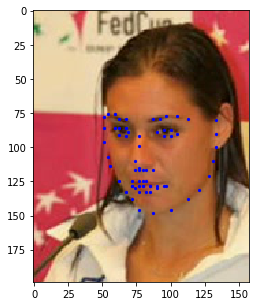

In [11]:
# 展示单条数据

n = 14 # n为数据在表格中的索引 
image_name = key_pts_frame.iloc[n, 0] # 获取图像名称
key_pts = key_pts_frame.iloc[n, 1:].to_numpy() # 将图像label格式转为numpy.array的格式
key_pts = key_pts.astype('float').reshape(-1) # 获取图像关键点信息
print(key_pts.shape)
plt.figure(figsize=(5, 5)) # 展示的图像大小
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts) # 展示图像与关键点信息
plt.show() # 展示图像

### 2.3 数据集定义

使用飞桨框架高层API的 ``paddle.io.Dataset`` 自定义数据集类，具体可以参考官网文档 [自定义数据集](https://www.paddlepaddle.org.cn/documentation/docs/zh/guides/02_paddle2.0_develop/02_data_load_cn.html#id3)。

### 作业1：自定义 Dataset，完成人脸关键点数据集定义 

按照 ``__init__`` 中的定义，实现 ``__getitem__`` 和 ``__len__``.

In [13]:
# 按照Dataset的使用规范，构建人脸关键点数据集

from paddle.io import Dataset

class FacialKeypointsDataset(Dataset):
    # 人脸关键点数据集
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, csv_file, root_dir, transform=None):
        """
        步骤二：实现构造函数，定义数据集大小
        Args:
            csv_file (string): 带标注的csv文件路径
            root_dir (string): 图片存储的文件夹路径
            transform (callable, optional): 应用于图像上的数据处理方法
        """
        self.key_pts_frame = pd.read_csv(csv_file) # 读取csv文件
        self.root_dir = root_dir # 获取图片文件夹路径
        self.transform = transform # 获取 transform 方法

    def __getitem__(self, idx):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """

        # 实现 __getitem__
        image_name = os.path.join(self.root_dir,self.key_pts_frame.iloc[idx,0])

        # 获取图像
        image = mpimg.imread(image_name)

        # 图像格式处理，如果包含alpha通道，忽略该图片
        if(image.shape[2]==4):
            image = image[:,:,0:3]
        
        # 获取关键点信息
        key_pts = self.key_pts_frame.iloc[idx,1:].to_numpy()
        key_pts = key_pts.astype('float').reshape(-1)

        # 如果定义了transform方法，使用transform方法
        if self.transform:
            image,key_pts = self.transform([image,key_pts])
        
        # 转为numpy格式
        image = np.array(image,dtype='float32')
        key_pts = np.array(key_pts,dtype='float32')

        return image, key_pts

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        
        # 实现 __len__
        # 返回数据集大小
        return len(self.key_pts_frame)
        

### 2.4 训练集可视化
实例化数据集并显示一些图像。

数据集大小为:  3462
0 (132, 147, 3) (136,)
1 (210, 158, 3) (136,)
2 (123, 121, 3) (136,)


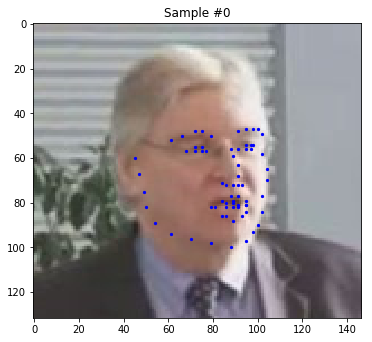

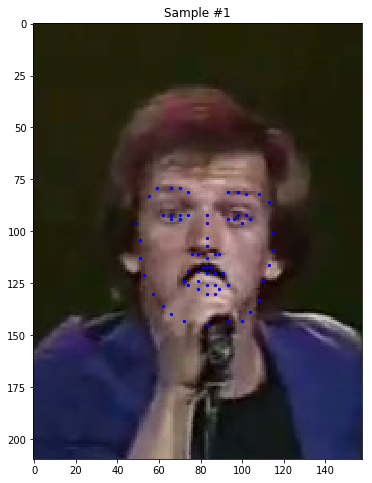

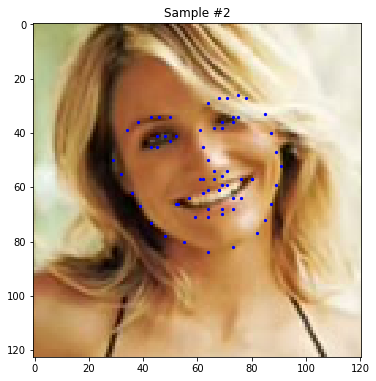

In [14]:
# 构建一个数据集类
face_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                      root_dir='data/training/')

# 输出数据集大小
print('数据集大小为: ', len(face_dataset))
# 根据 face_dataset 可视化数据集
num_to_display = 3

for i in range(num_to_display):
    
    # 定义图片大小
    fig = plt.figure(figsize=(20,10))
    
    # 随机选择图片
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # 输出图片大小和关键点的数量
    print(i, sample[0].shape, sample[1].shape)

    # 设置图片打印信息
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # 输出图片
    show_keypoints(sample[0], sample[1])

上述代码虽然完成了数据集的定义，但是还有一些问题，如：
- 每张图像的大小不一样，图像大小需要统一以适配网络输入要求
- 图像格式需要适配模型的格式输入要求
- 数据量比较小，没有进行数据增强

这些问题都会影响模型最终的性能，所以需要对数据进行预处理。

### 2.5 Transforms

对图像进行预处理，包括灰度化、归一化、重新设置尺寸、随机裁剪，修改通道格式等等，以满足数据要求；每一类的功能如下：
- 灰度化：丢弃颜色信息，保留图像边缘信息；识别算法对于颜色的依赖性不强，加上颜色后鲁棒性会下降，而且灰度化图像维度下降（3->1），保留梯度的同时会加快计算。
- 归一化：加快收敛
- 重新设置尺寸：数据增强
- 随机裁剪：数据增强
- 修改通道格式：改为模型需要的结构

### 作业2：实现自定义ToCHW

实现数据预处理方法 ToCHW

In [15]:
# 标准化自定义 transform 方法

class TransformAPI(object):
    """
    步骤一：继承 object 类
    """
    def __call__(self, data):

        """
        步骤二：在 __call__ 中定义数据处理方法
        """
        
        processed_data = data
        return  processed_data

In [16]:
import paddle.vision.transforms.functional as F

class GrayNormalize(object):
    # 将图片变为灰度图，并将其值放缩到[0, 1]
    # 将 label 放缩到 [-1, 1] 之间

    def __call__(self, data):
        image = data[0]   # 获取图片
        key_pts = data[1] # 获取标签
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # 灰度化图片
        gray_scale = paddle.vision.transforms.Grayscale(num_output_channels=3)
        image_copy = gray_scale(image_copy)
        
        # 将图片值放缩到 [0, 1]
        image_copy = image_copy / 255.0
        
        # 将坐标点放缩到 [-1, 1]
        mean = data_mean # 获取标签均值
        std = data_std   # 获取标签标准差
        key_pts_copy = (key_pts_copy - mean)/std

        return image_copy, key_pts_copy

class Resize(object):
    # 将输入图像调整为指定大小

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, data):

        image = data[0]    # 获取图片
        key_pts = data[1]  # 获取标签

        image_copy = np.copy(image)      
        key_pts_copy = np.copy(key_pts)

        h, w = image_copy.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = F.resize(image_copy, (new_h, new_w))
        
        # scale the pts, too
        key_pts_copy[::2] = key_pts_copy[::2] * new_w / w
        key_pts_copy[1::2] = key_pts_copy[1::2] * new_h / h

        return img, key_pts_copy


class RandomCrop(object):
    # 随机位置裁剪输入的图像

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, data):
        image = data[0]
        key_pts = data[1]

        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        h, w = image_copy.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image_copy = image_copy[top: top + new_h,
                      left: left + new_w]

        key_pts_copy[::2] = key_pts_copy[::2] - left
        key_pts_copy[1::2] = key_pts_copy[1::2] - top

        return image_copy, key_pts_copy

class ToCHW(object):
    # 将图像的格式由HWC改为CHW
    def __call__(self, data):

        # 实现ToCHW，可以使用 paddle.vision.transforms.Transpose 实现
        image = data[0]
        key_pts = data[1]
        
        #HWC改为CHW
        transforms = T.Transpose((2,0,1))
        image = transforms(image)

        return image, key_pts

看一下每种图像预处理方法的的效果。

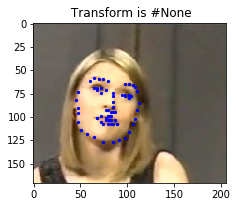

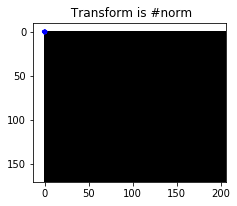

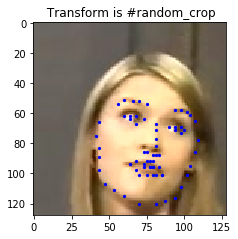

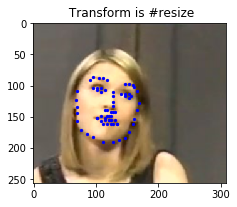

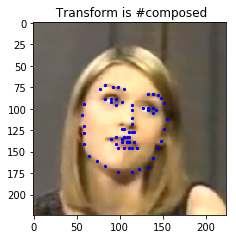

In [17]:
import paddle.vision.transforms as T

# 测试 Resize
resize = Resize(256)

# 测试 RandomCrop
random_crop = RandomCrop(128)

# 测试 GrayNormalize
norm = GrayNormalize()

# 测试 Resize + RandomCrop，图像大小变到250*250， 然后截取出224*224的图像块
composed = paddle.vision.transforms.Compose([Resize(250), RandomCrop(224)])

test_num = 800 # 测试的数据下标
data = face_dataset[test_num]

transforms = {'None': None, 
              'norm': norm,
              'random_crop': random_crop,
              'resize': resize ,
              'composed': composed}
for i, func_name in enumerate(['None', 'norm', 'random_crop', 'resize', 'composed']):
    
    # 定义图片大小
    fig = plt.figure(figsize=(20,10))
    
    # 处理图片
    if transforms[func_name] != None:
        transformed_sample = transforms[func_name](data)
    else:
        transformed_sample = data

    # 设置图片打印信息
    ax = plt.subplot(1, 5, i + 1)
    ax.set_title(' Transform is #{}'.format(func_name))
    
    # 输出图片
    show_keypoints(transformed_sample[0], transformed_sample[1])

### 2.6 使用数据预处理的方式完成数据定义

让我们将 ``Resize、RandomCrop、GrayNormalize、ToCHW`` 应用于新的数据集

In [18]:
from paddle.vision.transforms import Compose

data_transform = Compose([Resize(256), RandomCrop(224), GrayNormalize(), ToCHW()])

# create the transformed dataset
train_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                       root_dir='data/training/',
                                       transform=data_transform)
print('Number of train dataset images: ', len(train_dataset))

for i in range(4):
    sample = train_dataset[i]
    print(i, sample[0].shape, sample[1].shape)

test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

print('Number of test dataset images: ', len(test_dataset))

Number of train dataset images:  3462
0 (3, 224, 224) (136,)
1 (3, 224, 224) (136,)
2 (3, 224, 224) (136,)
3 (3, 224, 224) (136,)
Number of test dataset images:  770


##  3、模型组建

### 3.1 组网可以很简单

根据前文的分析可知，人脸关键点检测和分类，可以使用同样的网络结构，如LeNet、Resnet50等完成特征的提取，只是在原来的基础上，需要修改模型的最后部分，将输出调整为 人脸关键点的数量*2，即每个人脸关键点的横坐标与纵坐标，就可以完成人脸关键点检测任务了，具体可以见下面的代码，也可以参考官网案例:[人脸关键点检测](https://www.paddlepaddle.org.cn/documentation/docs/zh/tutorial/cv_case/landmark_detection/landmark_detection.html)

网络结构如下：
![](https://ai-studio-static-online.cdn.bcebos.com/acb845e2651647628e71462e356045dd4fdbdfe570364fe99224af20d39a4576)

### 作业3：根据上图，实现网络结构

In [19]:
import paddle.nn as nn
from paddle.vision.models import resnet50
class SimpleNet(nn.Layer):
    
    def __init__(self, key_pts):

        super(SimpleNet, self).__init__()

        # 实现 __init__
        # resnet50
        self.backbone = resnet50(pretrained=True)
        # 线性变换层
        self.linear1 = nn.Linear(in_features=1000,out_features=512)
        # relu激活函数
        self.act1 = nn.ReLU()
        # 线性变换层作为输出层，输出关键点的坐标,个数key_pts*2
        self.linear2 = nn.Linear(in_features=512,out_features=key_pts*2)

    def forward(self, x):

        # 实现 forward
        x = self.backbone(x)
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)

        return x

### 3.2 网络结构可视化
使用``model.summary``可视化网络结构。

In [20]:
model = paddle.Model(SimpleNet(key_pts=68))
model.summary((-1, 3, 224, 224))

2021-03-22 18:51:25,891 - INFO - unique_endpoints {''}
2021-03-22 18:51:25,893 - INFO - Downloading resnet50.pdparams from https://paddle-hapi.bj.bcebos.com/models/resnet50.pdparams
100%|██████████| 151272/151272 [00:03<00:00, 48623.42it/s]
2021-03-22 18:51:29,257 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet50.pdparams md5 checking...


-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-1        [[1, 3, 224, 224]]   [1, 64, 112, 112]        9,408     
   BatchNorm2D-1    [[1, 64, 112, 112]]   [1, 64, 112, 112]         256      
      ReLU-1        [[1, 64, 112, 112]]   [1, 64, 112, 112]          0       
    MaxPool2D-1     [[1, 64, 112, 112]]    [1, 64, 56, 56]           0       
     Conv2D-3        [[1, 64, 56, 56]]     [1, 64, 56, 56]         4,096     
   BatchNorm2D-3     [[1, 64, 56, 56]]     [1, 64, 56, 56]          256      
      ReLU-2         [[1, 256, 56, 56]]    [1, 256, 56, 56]          0       
     Conv2D-4        [[1, 64, 56, 56]]     [1, 64, 56, 56]        36,864     
   BatchNorm2D-4     [[1, 64, 56, 56]]     [1, 64, 56, 56]          256      
     Conv2D-5        [[1, 64, 56, 56]]     [1, 256, 56, 56]       16,384     
   BatchNorm2D-5     [[1, 256, 56, 56]]    [1, 256, 56, 56]   

{'total_params': 26192432, 'trainable_params': 26086192}

## 四、模型训练

### 4.1 模型配置
训练模型前，需要设置训练模型所需的优化器，损失函数和评估指标。
- 优化器：Adam优化器，快速收敛。
- 损失函数：SmoothL1Loss
- 评估指标：NME

### 4.2 自定义评估指标
特定任务的 Metric 计算方式在框架既有的 Metric接口中不存在，或算法不符合自己的需求，那么需要我们自己来进行Metric的自定义。这里介绍如何进行Metric的自定义操作，更多信息可以参考官网文档[自定义Metric](https://www.paddlepaddle.org.cn/documentation/docs/zh/guides/02_paddle2.0_develop/07_customize_cn.html#metric)；首先来看下面的代码。

In [21]:

from paddle.metric import Metric

class NME(Metric):
    """
    1. 继承paddle.metric.Metric
    """
    def __init__(self, name='nme', *args, **kwargs):
        """
        2. 构造函数实现，自定义参数即可
        """
        super(NME, self).__init__(*args, **kwargs)
        self._name = name
        self.rmse = 0
        self.sample_num = 0
    
    def name(self):
        """
        3. 实现name方法，返回定义的评估指标名字
        """
        return self._name
    
    def update(self, preds, labels):
        """
        4. 实现update方法，用于单个batch训练时进行评估指标计算。
        - 当`compute`类函数未实现时，会将模型的计算输出和标签数据的展平作为`update`的参数传入。
        """
        N = preds.shape[0]

        preds = preds.reshape((N, -1, 2))
        labels = labels.reshape((N, -1, 2))

        self.rmse = 0
        
        for i in range(N):
            pts_pred, pts_gt = preds[i, ], labels[i, ]
            interocular = np.linalg.norm(pts_gt[36, ] - pts_gt[45, ])

            self.rmse += np.sum(np.linalg.norm(pts_pred - pts_gt, axis=1)) / (interocular * preds.shape[1])
            self.sample_num += 1

        return self.rmse / N
    
    def accumulate(self):
        """
        5. 实现accumulate方法，返回历史batch训练积累后计算得到的评价指标值。
        每次`update`调用时进行数据积累，`accumulate`计算时对积累的所有数据进行计算并返回。
        结算结果会在`fit`接口的训练日志中呈现。
        """
        return self.rmse / self.sample_num
    
    def reset(self):
        """
        6. 实现reset方法，每个Epoch结束后进行评估指标的重置，这样下个Epoch可以重新进行计算。
        """
        self.rmse = 0
        self.sample_num = 0

### 作业4：实现模型的配置和训练

In [22]:
# 使用 paddle.Model 封装模型
model = paddle.Model(SimpleNet(key_pts=68))

# 定义Adam优化器
optimizer = paddle.optimizer.Adam(learning_rate=0.001,
                                    weight_decay=5e-4,
                                    parameters=model.parameters())

# 定义SmoothL1Loss
loss = nn.SmoothL1Loss()

# 使用自定义metrics
metrics = NME()

# 配置模型
model.prepare(optimizer=optimizer,loss=loss,metrics=metrics)

# 模型训练
model.fit(train_dataset,epochs=50,batch_size=64,verbose=1)

2021-03-22 18:51:46,413 - INFO - unique_endpoints {''}
2021-03-22 18:51:46,414 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet50.pdparams md5 checking...
2021-03-22 18:51:46,855 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet50.pdparams


The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/50
step 55/55 [==============================] - loss: 0.0931 - nme: 5.9317e-04 - 551ms/step     
Epoch 2/50
step 55/55 [==============================] - loss: 0.0582 - nme: 5.5541e-04 - 535ms/step     
Epoch 3/50
step 55/55 [==============================] - loss: 0.1466 - nme: 9.1330e-04 - 541ms/step     
Epoch 4/50
step 55/55 [==============================] - loss: 0.0348 - nme: 3.7001e-04 - 535ms/step     
Epoch 5/50
step 55/55 [==============================] - loss: 0.0356 - nme: 3.8605e-04 - 541ms/step     
Epoch 6/50
step 55/55 [==============================] - loss: 0.0422 - nme: 4.1559e-04 - 538ms/step     
Epoch 7/50
step 55/55 [==============================] - loss: 0.1641 - nme: 7.9728e-04 - 556ms/step     
Epoch 8/50
step 55/55 [==============================] - loss: 0.0164 - nme: 2.4082e-04 - 551ms/step     
Epoch 9/50
step 55/55 [====================

**损失函数的选择**：L1Loss、L2Loss、SmoothL1Loss的对比
- L1Loss: 在训练后期，预测值与ground-truth差异较小时， 损失对预测值的导数的绝对值仍然为1，此时如果学习率不变，损失函数将在稳定值附近波动，难以继续收敛达到更高精度。
- L2Loss: 在训练初期，预测值与ground-truth差异较大时，损失函数对预测值的梯度十分大，导致训练不稳定。
- SmoothL1Loss:  在x较小时，对x梯度也会变小，而在x很大时，对x的梯度的绝对值达到上限 1，也不会太大以至于破坏网络参数。

### 4.2 模型训练

In [ ]:
 #model.fit(train_dataset,epochs=50,batch_size=64,verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/50
step 55/55 [==============================] - loss: 0.1023 - nme: 6.9530e-04 - 519ms/step     
Epoch 2/50
step 55/55 [==============================] - loss: 0.0777 - nme: 6.4494e-04 - 523ms/step     
Epoch 3/50
step 55/55 [==============================] - loss: 0.0566 - nme: 5.6187e-04 - 526ms/step     
Epoch 4/50
step 55/55 [==============================] - loss: 0.0311 - nme: 3.2200e-04 - 522ms/step     
Epoch 5/50
step 55/55 [==============================] - loss: 0.0464 - nme: 4.2836e-04 - 522ms/step     
Epoch 6/50
step 55/55 [==============================] - loss: 0.0280 - nme: 3.6241e-04 - 520ms/step     
Epoch 7/50
step 55/55 [==============================] - loss: 0.0722 - nme: 5.5169e-04 - 524ms/step     
Epoch 8/50
step 55/55 [==============================] - loss: 0.0458 - nme: 4.0415e-04 - 522ms/step     
Epoch 9/50
step 55/55 [====================

### 4.3 模型保存

In [23]:
checkpoints_path = './checkpoints/models'
model.save(checkpoints_path)

## 五、模型预测

In [24]:
# 定义功能函数

def show_all_keypoints(image, predicted_key_pts):
    """
    展示图像，预测关键点
    Args：
        image：裁剪后的图像 [224, 224, 3]
        predicted_key_pts: 预测关键点的坐标
    """
    # 展示图像
    plt.imshow(image.astype('uint8'))

    # 展示关键点
    for i in range(0, len(predicted_key_pts), 2):
        plt.scatter(predicted_key_pts[i], predicted_key_pts[i+1], s=20, marker='.', c='m')

def visualize_output(test_images, test_outputs, batch_size=1, h=20, w=10):
    """
    展示图像，预测关键点
    Args：
        test_images：裁剪后的图像 [224, 224, 3]
        test_outputs: 模型的输出
        batch_size: 批大小
        h: 展示的图像高
        w: 展示的图像宽
    """

    if len(test_images.shape) == 3:
        test_images = np.array([test_images])

    for i in range(batch_size):

        plt.figure(figsize=(h, w))
        ax = plt.subplot(1, batch_size, i+1)

        # 随机裁剪后的图像
        image = test_images[i]

        # 模型的输出，未还原的预测关键点坐标值
        predicted_key_pts = test_outputs[i]

        # 还原后的真实的关键点坐标值
        predicted_key_pts = predicted_key_pts * data_std + data_mean
        
        # 展示图像和关键点
        show_all_keypoints(np.squeeze(image), predicted_key_pts)
            
        plt.axis('off')

    plt.show()

2021-03-22 19:17:27,157 - INFO - unique_endpoints {''}
2021-03-22 19:17:27,159 - INFO - File /home/aistudio/.cache/paddle/hapi/weights/resnet50.pdparams md5 checking...
2021-03-22 19:17:27,603 - INFO - Found /home/aistudio/.cache/paddle/hapi/weights/resnet50.pdparams


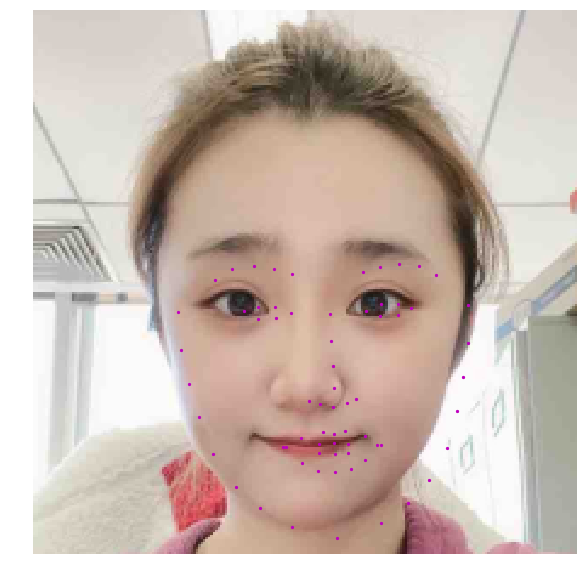

In [26]:
 # 读取图像
img = mpimg.imread('xiaojiejie.jpg')

# 关键点占位符
kpt = np.ones((136, 1))

transform = Compose([Resize(256), RandomCrop(224)])

# 对图像先重新定义大小，并裁剪到 224*224的大小
rgb_img, kpt = transform([img, kpt])

norm = GrayNormalize()
to_chw = ToCHW()

# 对图像进行归一化和格式变换
img, kpt = norm([rgb_img, kpt])
img, kpt = to_chw([img, kpt])

img = np.array([img], dtype='float32')

# 加载保存好的模型进行预测
model = paddle.Model(SimpleNet(key_pts=68))
model.load(checkpoints_path)
model.prepare()

# 预测结果
out = model.predict_batch([img])
out = out[0].reshape((out[0].shape[0], 136, -1))

# 可视化
visualize_output(rgb_img, out, batch_size=1)

## 六、趣味应用

当我们得到关键点的信息后，就可以进行一些趣味的应用。

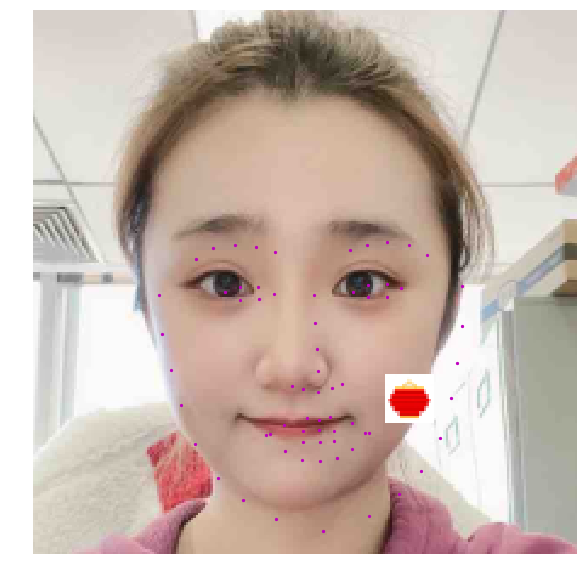

In [28]:
# 定义功能函数

def show_fu(image, predicted_key_pts):
    """
    展示加了贴纸的图像
    Args：
        image：裁剪后的图像 [224, 224, 3]
        predicted_key_pts: 预测关键点的坐标
    """
    # 计算坐标，15 和 34点的中间值
    x = (int(predicted_key_pts[28]) + int(predicted_key_pts[66]))//2
    y = (int(predicted_key_pts[29]) + int(predicted_key_pts[67]))//2

    # 打开 春节小图
    star_image = mpimg.imread('light.jpg')

    # 处理通道
    if(star_image.shape[2] == 4):
        star_image = star_image[:,:,1:4]
    
    # 将春节小图放到原图上
    image[y:y+len(star_image[0]), x:x+len(star_image[1]),:] = star_image
    
    # 展示处理后的图片
    plt.imshow(image.astype('uint8'))

    # 展示关键点信息
    for i in range(len(predicted_key_pts)//2,):
        plt.scatter(predicted_key_pts[i*2], predicted_key_pts[i*2+1], s=20, marker='.', c='m') # 展示关键点信息


def custom_output(test_images, test_outputs, batch_size=1, h=20, w=10):
    """
    展示图像，预测关键点
    Args：
        test_images：裁剪后的图像 [224, 224, 3]
        test_outputs: 模型的输出
        batch_size: 批大小
        h: 展示的图像高
        w: 展示的图像宽
    """

    if len(test_images.shape) == 3:
        test_images = np.array([test_images])

    for i in range(batch_size):

        plt.figure(figsize=(h, w))
        ax = plt.subplot(1, batch_size, i+1)

        # 随机裁剪后的图像
        image = test_images[i]

        # 模型的输出，未还原的预测关键点坐标值
        predicted_key_pts = test_outputs[i]

        # 还原后的真实的关键点坐标值
        predicted_key_pts = predicted_key_pts * data_std + data_mean
        
        # 展示图像和关键点
        show_fu(np.squeeze(image), predicted_key_pts)
            
        plt.axis('off')

    plt.show()

# 读取图像
img = mpimg.imread('xiaojiejie.jpg')

# 关键点占位符
kpt = np.ones((136, 1))

transform = Compose([Resize(256), RandomCrop(224)])

# 对图像先重新定义大小，并裁剪到 224*224的大小
rgb_img, kpt = transform([img, kpt])

norm = GrayNormalize()
to_chw = ToCHW()

# 对图像进行归一化和格式变换
img, kpt = norm([rgb_img, kpt])
img, kpt = to_chw([img, kpt])

img = np.array([img], dtype='float32')

# 加载保存好的模型进行预测
# model = paddle.Model(SimpleNet())
# model.load(checkpoints_path)
# model.prepare()

# 预测结果
out = model.predict_batch([img])
out = out[0].reshape((out[0].shape[0], 136, -1))

# 可视化
custom_output(rgb_img, out, batch_size=1)

### 作业6：实现趣味PS

根据人脸检测的结果，实现趣味PS。